# 2D ring resonator

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FRingResonator.ipynb). View this project in [Tidy3D Web App](https://tidy3d.simulation.cloud/workbench?taskId=4b6c5361-8274-4a9b-8d4d-e0c51f31ef6f).

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size and the large number of time steps needed to capture the resonance of the ring. However, it can be easily handled with Tidy3D.

In [11]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

<img src="img/ring_resonator_schematic.png" alt="schematic" width="300"/>

In [12]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

Define frequency parameters for sources and monitors based on the wavelength range of interest. Since in this case study we are investigating the system's response over a wide range of frequencies we will use a broadband mode source that takes into account frequency-dependent character of waveguide modes. The Tidy3D's broadband feature is designed in such a way that it produces the most accurate results in the range `(freq0 - 1.5 * fwidth, freq0 + 1.5 * fwidth)`, thus we define parameters `freq0` and `fwidth` such that the frequency range of interest is exactly covered by `(freq0 - 1.5 * fwidth, freq0 + 1.5 * fwidth)`.

In [13]:
# wavelength range of interest
lambda_beg = 0.4
lambda_end = 0.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

min_steps_per_wvl = 30
run_time = 1e-11

Define materials. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#mediums)

In [14]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#structures)


In [15]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

Compute and visualize the waveguide modes.

In [16]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0),
    structures=[background_box, waveguide],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic())
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0])
mode_data = mode_solver.solve()

[11:13:22] WARNING  No sources in simulation.                               ]8;id=924921;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=945781;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#494\494]8;;\

<Figure size 720x432 with 6 Axes>

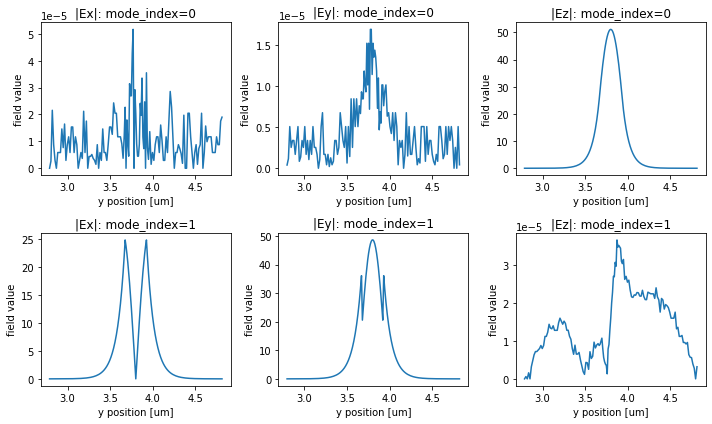

In [17]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
mode_data.Ex.sel(mode_index=0, f=freq0).abs.plot(ax=ax1)
mode_data.Ey.sel(mode_index=0, f=freq0).abs.plot(ax=ax2)
mode_data.Ez.sel(mode_index=0, f=freq0).abs.plot(ax=ax3)
mode_data.Ex.sel(mode_index=1, f=freq0).abs.plot(ax=ax4)
mode_data.Ey.sel(mode_index=1, f=freq0).abs.plot(ax=ax5)
mode_data.Ez.sel(mode_index=1, f=freq0).abs.plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it. As mentioned before, we will use a broadband mode source that will approximate the chosen mode's frequency dependence in the range `(freq0 - 1.5 * fwidth, freq0 + 1.5 * fwidth)` using 11 Chebyshev polynomials.

In [18]:
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+',
    num_freqs=11,  # using 11 (Chebyshev) points to approximate frequency dependence
)

In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [19]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')


# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(lambda_beg, lambda_end, 1001)
freqs_measure = td.C_0 / lambdas_measure[::-1]

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor = mode_monitor.copy(update=dict(center = [+wg_insert_x, wg_center_y, 0]))

Define simulation. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#simulation)
To make the simulation 2D, we can just set the simulation size in one of the dimensions to be 0. However, note that we still have to define a grid size in that direction. Additionally, we lower the shutoff factor to make sure the high-frequency response of this resonant system is accurately resolved.

In [20]:
# create simulation
sim = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0),
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
    shutoff=1e-9,
)

Visualize structure, source, and modes. [(docs)](https://docs.simulation.cloud/en/latest/howdoi.html#plot-data)

<Figure size 432x432 with 2 Axes>

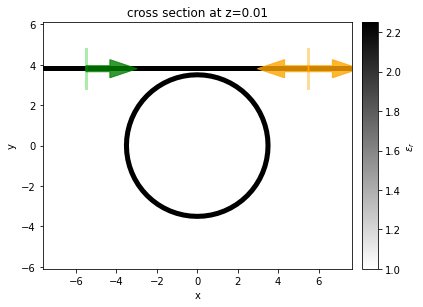

In [11]:
# plot the two simulations
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sim.plot_eps(z=0.01, ax=ax)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://docs.simulation.cloud/en/latest/api.html#submitting-simulations)

In [12]:
# use function above to run simulation 
sim_data = web.run(sim, task_name='ring_resonator', path='data/simulation_data.hdf5')

           INFO     Using Tidy3D credentials from stored file.                     ]8;id=178897;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=457872;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#70\70]8;;\

[18:23:55] INFO     Authentication successful.                                     ]8;id=721704;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=299101;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#30\30]8;;\

[18:23:56] INFO     Created task 'ring_resonator' with task_id                  ]8;id=340642;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=864351;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'fe3c81e4-dd96-4474-901d-ef99aa96bc61'.                                  

Output()

[18:23:57] INFO     Maximum FlexUnit cost: 0.253                                ]8;id=974409;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=309459;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                             ]8;id=388535;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=351879;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#261\261]8;;\

Output()

[18:24:00] INFO     status = preprocess                                         ]8;id=251045;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=803962;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#273\273]8;;\

[18:24:05] INFO     starting up solver                                          ]8;id=586319;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=739215;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#277\277]8;;\

[18:24:28] INFO     running solver                                              ]8;id=972526;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=133798;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#283\283]8;;\

Output()

[18:26:19] INFO     early shutoff detected, exiting.                            ]8;id=389816;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=376097;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                        ]8;id=222548;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=315301;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#300\300]8;;\

Output()

[18:26:32] INFO     status = success                                            ]8;id=512284;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=539210;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.243                                 ]8;id=259015;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=245208;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=445281;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=954845;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#592\592]8;;\
                    "data/simulation_data.hdf5"                                              

Output()

[18:26:36] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=965969;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=721013;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#414\414]8;;\

In [13]:
print(sim_data.log)

Simulation domain Nx, Ny, Nz: [1433, 1001, 1]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.4393e+06.
Using subpixel averaging: True
Number of time steps: 4.6047e+05
Automatic shutoff factor: 1.00e-09
Time step (s): 2.1717e-17


Compute source modes time (s):     1.7768
Compute monitor modes time (s):    110.9567
Rest of setup time (s):            10.8864

Running solver for 460471 time steps...
- Time step    440 / time 9.56e-15s (  0 % done), field decay: 1.00e+00
- Time step  18418 / time 4.00e-13s (  4 % done), field decay: 2.03e-01
- Time step  36837 / time 8.00e-13s (  8 % done), field decay: 1.89e-02
- Time step  55256 / time 1.20e-12s ( 12 % done), field decay: 4.68e-03
- Time step  73675 / time 1.60e-12s ( 16 % done), field decay: 1.01e-03
- Time step  92094 / time 2.00e-12s ( 20 % done), field decay: 3.39e-04
- Time step 110513 / time 2.40e-12s ( 24 % done), field decay: 1.35e-04
- Time step 128931 / time 2.80e-12s ( 28 % done), field decay: 4.18e-05
- 

<Figure size 1080x432 with 4 Axes>

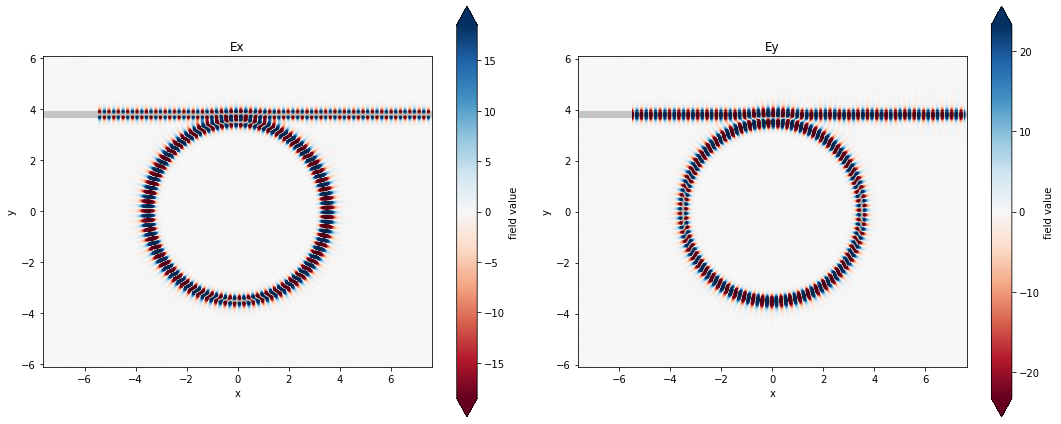

In [14]:
# visualize normalization run
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 6))

ax1 = sim_data.plot_field('field', 'Ex', val='real', z=0, ax=ax1)
ax2 = sim_data.plot_field('field', 'Ey', val='real', z=0, ax=ax2)
ax1.set_title('Ex')
ax2.set_title('Ey')

plt.show()

## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [15]:
sim_data['mode'].amps

<xarray.ModeAmpsDataArray (direction: 2, f: 1001, mode_index: 2)>
array([[[-1.27228285e-07+1.93114125e-07j,
 -9.90342063e-01-3.09109412e-02j],
 [ 6.40936866e-08+1.90399395e-07j,
 -9.80814112e-01-1.40976772e-01j],
 [ 2.23946689e-07+2.19753956e-07j,
 -9.58727946e-01-2.50409607e-01j],
 ...,
 [-1.16812559e-07+6.89954062e-08j,
 3.12045632e-01-9.49995321e-01j],
 [-3.35518463e-07+2.04260623e-07j,
 4.59846595e-01-8.87904341e-01j],
 [-4.31400983e-07+1.49033071e-07j,
 5.98078371e-01-8.01217452e-01j]],

 [[ 1.85592892e-09+7.80862030e-10j,
 -1.09921095e-05-8.99535549e-05j],
 [ 9.89061559e-09-4.09757933e-10j,
 -1.62073811e-05-6.42821364e-05j],
 [ 1.62798405e-08+3.22998360e-09j,
 -2.37364261e-05-6.40256253e-05j],
 ...,
 [ 9.62290546e-10-4.52698563e-09j,
 2.69287517e-04+6.53467658e-05j],
 [ 1.70808352e-10-1.14896296e-09j,
 3.00599786e-04+1.34636139e-04j],
 [-1.30603267e-10+1.03233031e-09j,
 2.23401136e-04+1.85317607e-04j]]])
Coordinates:
 * direction (direction) object '+' '-'
 * f (f) float64 4.997e+14 4.998e+14 5e+14 ... 7.491e+14 7.495e+14
 * mode_index (mode_index) int64 0 1
Attributes:
 long_name: mode amplitudes
 units: sqrt(W) xarray.ModeAmpsDataArray direction : 2 f : 1001 mode_index : 2 (-1.2722828526670866e-07+1.9311412503268218e-07j) ... (0.0002234011... array([[[-1.27228285e-07+1.93114125e-07j,
 -9.90342063e-01-3.09109412e-02j],
 [ 6.40936866e-08+1.90399395e-07j,
 -9.80814112e-01-1.40976772e-01j],
 [ 2.23946689e-07+2.19753956e-07j,
 -9.58727946e-01-2.50409607e-01j],
 ...,
 [-1.16812559e-07+6.89954062e-08j,
 3.12045632e-01-9.49995321e-01j],
 [-3.35518463e-07+2.04260623e-07j,
 4.59846595e-01-8.87904341e-01j],
 [-4.31400983e-07+1.49033071e-07j,
 5.98078371e-01-8.01217452e-01j]],

 [[ 1.85592892e-09+7.80862030e-10j,
 -1.09921095e-05-8.99535549e-05j],
 [ 9.89061559e-09-4.09757933e-10j,
 -1.62073811e-05-6.42821364e-05j],
 [ 1.62798405e-08+3.22998360e-09j,
 -2.37364261e-05-6.40256253e-05j],
 ...,
 [ 9.62290546e-10-4.52698563e-09j,
 2.69287517e-04+6.53467658e-05j],
 [ 1.70808352e-10-1.14896296e-09j,
 3.00599786e-04+1.34636139e-04j],
 [-1.30603267e-10+1.03233031e-09j,
 2.23401136e-04+1.85317607e-04j]]]) Coordinates: (3) direction (direction) object '+' '-' long_name : propagation direction array(['+', '-'], dtype=object) f (f) float64 4.997e+14 4.998e+14 ... 7.495e+14 long_name : frequency units : Hz array([4.996541e+14, 4.998207e+14, 4.999874e+14, ..., 7.487324e+14,
 7.491066e+14, 7.494811e+14]) mode_index (mode_index) int64 0 1 long_name : mode index array([0, 1]) Attributes: (2) long_name : mode amplitudes units : sqrt(W)

As we see, the mode amplitude data is complex-valued with three 3 dimensions:

- index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).

- direction of the propagation (for decomposition).

- frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency.

In [16]:
transmission_amps = sim_data['mode'].amps.sel(mode_index=1, direction='+')

Now let's plot the data.

<Figure size 720x360 with 1 Axes>

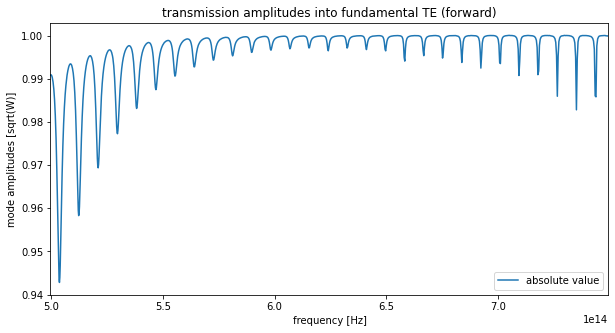

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
transmission_amps.abs.plot.line(x='f', ax=ax, label='absolute value')
# transmission_amps.real.abs.plot.line(x='f', ax=ax, label='|real|')
ax.legend()
ax.set_title('transmission amplitudes into fundamental TE (forward)')
# ax.set_ylim(0, 1)
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
plt.show()